In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [122]:
df = pd.read_csv('test4.txt', sep=',', header=None)
df.columns = ['sensor1', 'sensor2']
df

,sensor1,sensor2
0,5,5
1,5,5
2,5,5
3,5,5
4,5,5
...,...,...
99995,5,5
99996,5,5
99997,5,5
99998,5,5


In [123]:
print(df['sensor1'].unique()) # 0 is DROP DETECTED 
print(df['sensor2'].unique()) 

df = df.applymap(lambda x: 1 if x != 0 else 0)
print(df['sensor1'].unique()) # 0 is DROP DETECTED 
print(df['sensor2'].unique()) # 5,4,3,2,1 mapped to 1
df = df.applymap(lambda x: 1 if x == 0 else 0)

print(df['sensor1'].unique()) # 1 is DROP DETECTED 
print(df['sensor2'].unique()) 
df

[5 0 4 3 2]
[5 0 4 3 1]
[1 0]
[1 0]
[0 1]
[0 1]


,sensor1,sensor2
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
...,...,...
99995,0,0
99996,0,0
99997,0,0
99998,0,0


In [124]:
# need time between drops
df['OR'] = df['sensor1'] | df['sensor2'] # drop detected
df[df['sensor1']==0] # times wehre no drops were detected


,sensor1,sensor2,OR
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0
...,...,...,...
99995,0,0,0
99996,0,0,0
99997,0,0,0
99998,0,0,0


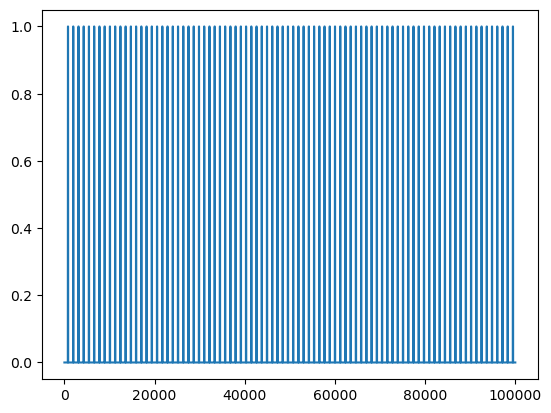

In [131]:
plt.plot(df['OR'])
plt.show()

[1110, 1111, 1107, 1106, 1111, 1113, 1110, 1111, 1110, 1106, 1110, 1108, 1107, 1108, 1111, 1110, 1112, 1111, 1109, 1109, 1110, 1111, 1108, 1108, 1110, 1107, 1109, 1109, 1109, 1107, 1111, 1106, 1107, 1106, 1111, 1109, 1107, 1110, 1107, 1109, 1109, 1109, 1108, 1105, 1108, 1107, 1109, 1108, 1104, 1105, 1108, 1110, 1105, 1108, 1108, 1109, 1106, 1108, 1109, 1108, 1110, 1108, 1111, 1107, 1111, 1107, 1110, 1111, 1108, 1110, 1109, 1111, 1108, 1109, 1106, 1109, 1110, 1111, 1107, 1105, 1105, 1110, 1109, 1108, 1108]
85
85


Text(0, 0.5, 'periods[i+1]')

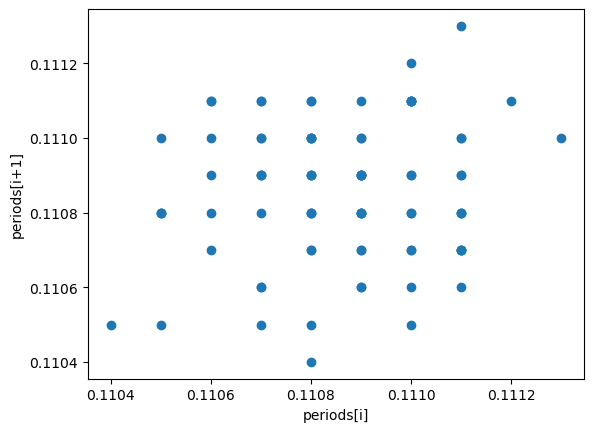

In [127]:
l = df['OR'].tolist() # list of 0s and 1s
# l = [0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,1]

periods = []
count_between_drop = 0

first_drop = l.index(1) # start at first occurrence of a drop
for i in range(first_drop, len(l)):
    if l[i] == 1 and count_between_drop != 0: # no drop detected AND count between drop != 0
        periods.append(count_between_drop)
        count_between_drop = 0
    if l[i] == 0: # no drop detected
        count_between_drop += 1 
            
print(periods)
f = 10000
print(len(periods))
periods = np.array(periods)*1/f # seconds
print(len(periods))

plt.scatter(periods[0:-1], periods[1:])
plt.xlabel('periods[i]')
plt.ylabel('periods[i+1]')
# plt.xlim(0,0.6)
# plt.ylim(0,0.6)

## ANALYSIS

In [178]:
from matplotlib.ticker import StrMethodFormatter

def analysis(file, fr, freq=10000, mute_period=False, xzoom=1, yzoom=1):
    """
    Given a file of sensor data and flow rate fr, 
    create Poincare section plots
    """
    df = pd.read_csv(file, sep=',', header=None)
    df.columns = ['sensor1', 'sensor2']
    print('Initial unique values of sensors')
    print(f'Sensor 1: {df["sensor1"].unique()}') # 0 is DROP DETECTED 
    print(f'Sensor 2: {df["sensor2"].unique()}')
    print(f'Transformation: nonzero -> 1')
    df = df.applymap(lambda x: 1 if x != 0 else 0)
    print(f'Sensor 1: {df["sensor1"].unique()}') # 0 is DROP DETECTED 
    print(f'Sensor 2: {df["sensor2"].unique()}') # 5,4,3,2,1 mapped to 1
    print(f'Transformation: Switch 0s and 1s')
    df = df.applymap(lambda x: 1 if x == 0 else 0)
    print(f'Sensor 1: {df["sensor1"].unique()}') # 1 is DROP DETECTED 
    print(f'Sensor 2: {df["sensor2"].unique()}')

    # OR Gate
    df['OR'] = df['sensor1'] | df['sensor2'] # detecting drops in either sensor

    if not mute_period:
        plt.figure()
        plt.title("Visualization of Periods")
        plt.plot(df['OR'])
        plt.xlabel('Time step')
        plt.ylabel('1 or 0')

    l = df['OR'].tolist() # list of 0s and 1s

    # counting time between drops
    periods = []
    count_between_drop = 0

    first_drop = l.index(1) # start at first occurrence of a drop
    for i in range(first_drop, len(l)):
        if l[i] == 1 and count_between_drop != 0: # no drop detected AND count between drop != 0
            periods.append(count_between_drop)
            count_between_drop = 0
        if l[i] == 0: # no drop detected
            count_between_drop += 1 

    periods = np.array(periods)*1/freq # convert to seconds

    fig, ax = plt.subplots()
    ax.set_title(f'Poincare Section Plots (Flow Rate: {fr:.2f}g/min)')
    ax.scatter(periods[0:-1], periods[1:])
    ax.set_xlabel('$T_{n} (s)$')
    ax.set_ylabel('$T_{n+1} (s)$')
    ax.xaxis.set_major_formatter(StrMethodFormatter(f'{{x:.3f}}'))
    ax.yaxis.set_major_formatter(StrMethodFormatter(f'{{x:.3f}}'))

    ax.set_xlim(0,xzoom)
    ax.set_ylim(0,yzoom)
    


Initial unique values of sensors
Sensor 1: [5 0 3 4]
Sensor 2: [5 0 4 1]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s


Sensor 1: [0 1]
Sensor 2: [0 1]


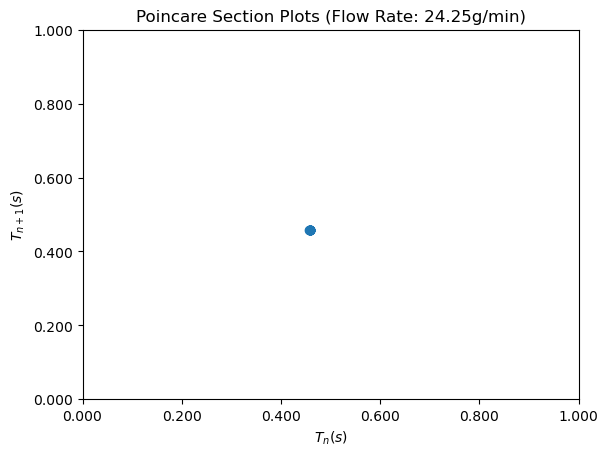

In [176]:
analysis('test3.txt', fr=24.2513, mute_period=True)

Initial unique values of sensors
Sensor 1: [5 0 4 2 3 1]
Sensor 2: [5 0 4 2 3 1]
Transformation: nonzero -> 1
Sensor 1: [1 0]
Sensor 2: [1 0]
Transformation: Switch 0s and 1s
Sensor 1: [0 1]
Sensor 2: [0 1]


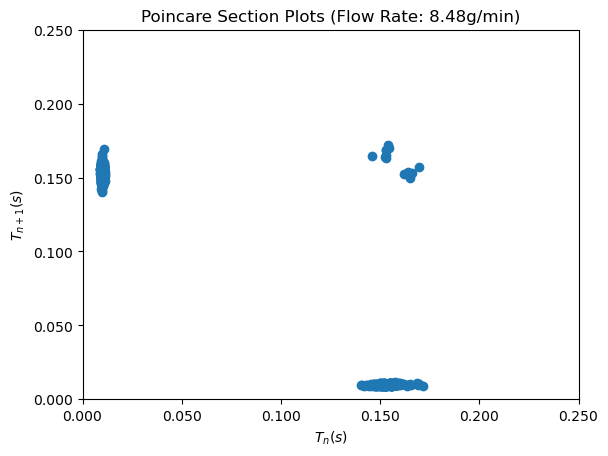

In [180]:
analysis('test5.txt', fr=0.1413*60, mute_period=True, xzoom=0.25, yzoom=0.25)